In [30]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
%matplotlib inline

### Convert mp3 data to wav format

In [32]:
from pydub import AudioSegment

path = './sounds/'                                                                    
src = 'Parus-Belgium-Geel, Antwerpen, Vlaanderen-call-A-399247.mp3'
dst = src[-10:-3] + 'wav' 

# convert wav to mp3                                                            
sound = AudioSegment.from_mp3(path + src)
sound.export(path + dst, format="wav")

<_io.BufferedRandom name='./sounds/399247.wav'>

### Listen to the example

In [33]:
import IPython.display as ipd  # To play sound in the notebook
fname = path + dst
ipd.Audio(fname)

In [34]:
from scipy.io import wavfile
rate, data = wavfile.read(fname)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  48000
Total samples (frames) =  (577152, 2)
[[  0   0]
 [  0   0]
 [  0   0]
 ...
 [135 135]
 [  7   7]
 [126 126]]


#### Now we will zoom on a row of 300 values of the initial time series

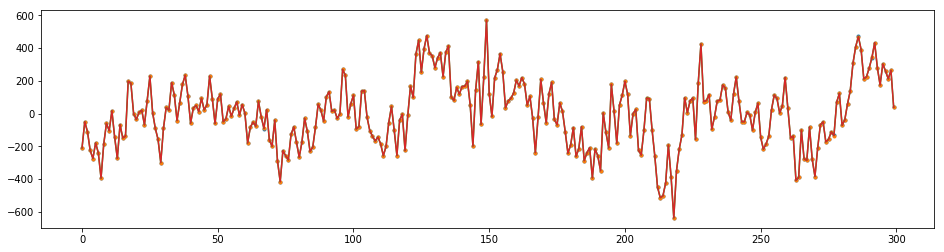

In [41]:
plt.figure(figsize=(16, 4))
plt.plot(data[5000:5300], '.'); plt.plot(data[5000:5300], '-');

## MFCC
MFCC - mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

In [60]:
import os
import librosa

In [63]:
wav, _ = librosa.core.load(fname)
mfcc = librosa.feature.mfcc(wav, n_mfcc=80)
mfcc.shape

(80, 518)

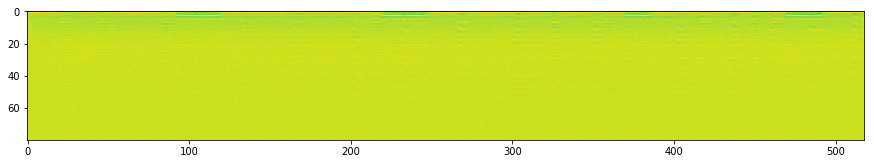

In [64]:
plt.figure(figsize=(15, 6))
plt.imshow(mfcc)

### Differencies between calls and songs

+ Calls

In [75]:
train_data = pd.read_csv('train_data.csv', index_col=0)

In [ ]:
path = './sounds/'
for file in train_data.loc[train_data.labels == 1]['id'][:10]:
    fname = path + str(file) + '.wav'
    ipd.Audio(fname)

In [ ]:
plt.figure(figsize=(16, 8))
for i, file in enumerate(train_data.loc[train_data.labels == 1]['id'][:10]):
    fname = path + str(file) + '.wav'
    rate, data = wavfile.read(fname)
    plt.subplot(2, 5, i + 1)
    plt.plot(data, '-')

+ Songs

In [ ]:
for file in train_data.loc[train_data.labels == 0]['id'][:10]:
    fname = path + str(file) + '.wav'
    ipd.Audio(fname)

In [ ]:
plt.figure(figsize=(16, 8))
for i, file in enumerate(train_data.loc[train_data.labels == 0]['id'][:10]):
    fname = path + str(file) + '.wav'
    rate, data = wavfile.read(fname)
    plt.subplot(2, 5, i + 1)
    plt.plot(data, '-')

Comparing MFCC

In [ ]:
plt.figure(figsize=(16, 8))
for i, file in enumerate(train_data.loc[train_data.labels == 1]['id'][:5]):
    fname = path + str(file) + '.wav'
    wav, _ = librosa.core.load(fname)
    mfcc = librosa.feature.mfcc(wav, n_mfcc=80)
    plt.subplot(2, 5, i + 1)
    plt.imshow(mfcc)
for i, file in enumerate(train_data.loc[train_data.labels == 0]['id'][:5]):
    fname = path + str(file) + '.wav'
    wav, _ = librosa.core.load(fname)
    plt.subplot(2, 5, i + 1)
    plt.imshow(mfcc)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import skew

from tqdm import tqdm, tqdm_pandas

tqdm.pandas()
import scipy

In [17]:
import pandas as pd 
import numpy as np

In [22]:
train_data = pd.read_csv('train_data.csv', index_col=0)
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,max_1_3,mean_1_1,mean_1_2,mean_1_3,min_1_1,min_1_2,min_1_3,std_1_1,std_1_2,std_1_3
0,-436.514074,127.301726,18.283442,-6.818973,-0.517332,17.952541,10.912547,12.669348,6.394881,10.341830,...,82.0,-60.507812,6.000000,13.750000,-745.0,-27.0,-39.0,152.676340,33.000000,49.342553
1,-239.074620,19.287065,-68.560588,-18.418223,-21.925773,-7.657923,-15.589265,-4.075395,-15.764188,-4.112783,...,-276.0,-0.031231,-0.034820,-276.000000,-24716.0,-24716.0,-276.0,1345.408317,1529.953017,0.000000
2,-367.704830,-31.474539,-108.760128,-90.779177,-75.426763,-23.981639,-25.067120,11.283314,3.798569,27.655528,...,263.0,-0.024872,-0.020410,129.500000,-14157.0,-8307.0,22.0,1053.871341,1009.831768,104.877309
3,-508.650269,-38.546771,-95.776263,4.488206,-46.348091,-5.754554,-7.404113,-8.611265,-5.022680,3.629960,...,4750.0,-0.025815,-0.025987,-0.025838,-4878.0,-4878.0,-4878.0,400.387684,423.783759,458.138427
4,-321.269150,-76.923236,-119.413991,-13.216269,-21.198838,-4.078821,-5.427807,-1.305652,1.698714,5.166934,...,25153.0,-0.437937,606.000000,-0.432579,-26579.0,606.0,-25425.0,1878.493997,0.000000,1678.134203


In [24]:
X = train_data.drop(['labels', 'id'], axis=1)
feature_names = list(X.columns)
X = X.values
labels = np.sort(np.unique(train_data.labels.values))
num_class = len(labels)
c2i = {}
i2c = {}
for i, c in enumerate(labels):
    c2i[c] = i
    i2c[i] = c
y = np.array([c2i[x] for x in train_data.labels.values])

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.7, random_state=10, shuffle = True)
clf = XGBClassifier(max_depth=5, learning_rate=0.05, n_estimators=3000,
                    n_jobs=-1, random_state=0, reg_alpha=0.2, 
                    colsample_bylevel=0.9, colsample_bytree=0.9, verbose=True)
clf.fit(X_train, y_train)
print(accuracy_score(clf.predict(X_val), y_val))

0.8397811645173896


In [ ]:
0.8528446389496718